## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [46]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  

a. Read in the dataset and take a look at the top few rows here:

In [47]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [48]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [49]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.loc[df.converted == 1, 'user_id'].nunique()/df.user_id.nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df[((df.group == 'treatment') & (df.landing_page != 'new_page')) | ((df.group != 'treatment') & (df.landing_page == 'new_page'))].shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum() # there is no missing value

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
#remove the rows that do not line up

index_to_drop = df[((df.group == 'treatment') & (df.landing_page != 'new_page')) | ((df.group != 'treatment') & (df.landing_page == 'new_page'))].index
df2 = df.drop(index_to_drop)
df2.shape

(290585, 5)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2.loc[df2.user_id.duplicated(), 'user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2.loc[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
index = df2.loc[df2.user_id.duplicated()].index
df2.drop(index,inplace = True)

In [14]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
p_control = df2.loc[df2.group == 'control', 'converted'].mean()
p_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
p_treat = df2.loc[df2.group == 'treatment', 'converted'].mean()
p_treat

0.11880806551510564

In [18]:
diff_real = p_treat - p_control
diff_real

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [19]:
df2.loc[df2.landing_page == 'new_page'].shape[0]/len(df2)

0.5000619442226688

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**Landing on old or new page is of equally probable that is 0.5. Using a Bayes Rule, the probability of convertion given that you are on old page is 2 * 0.12 = .24, whereas this probability of convertion given that user is on new page is 2 * .119 = .238. The probabilities are so close to each other. It might happen due to random chance. So we cannot say that there is evidence that one page leads to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

H_o : p_old = p_new
H_A : p_old < p_new

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [50]:
p_new = df2.converted.mean()
print(p_new)

0.119597087245


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [51]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [52]:
n_new = df2.loc[df2.group == 'treatment'].shape[0]
n_new

145310

d. What is $n_{old}$?

In [53]:
n_old = df2.loc[df2.group == 'control'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [54]:
new_page_converted = np.random.choice([0,1], size = n_new, p = [1-p_new, p_new])


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [55]:
old_page_converted = np.random.choice([0,1], size = n_old, p = [1-p_old, p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [56]:
diff = new_page_converted.mean() - old_page_converted.mean()
diff

0.0015052085179684677

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [57]:
p_diffs = list()
for i in range(10000):
    new_page = np.random.choice([0,1], size = n_new, p = [1-p_new, p_new])
    old_page = np.random.choice([0,1], size = n_old, p = [1-p_old, p_old])
    diff = new_page.mean() - old_page.mean()
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

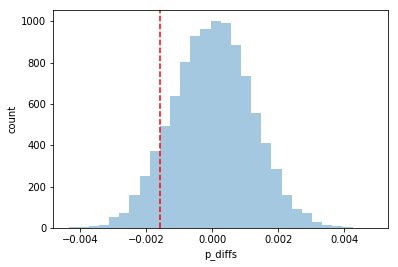

In [58]:
p_diffs = np.array(p_diffs)
fig , ax= plt.subplots()
sns.distplot(p_diffs, kde = False,bins = 30);
plt.axvline(diff_real, color = 'red', linestyle = '--');
ax.set(xlabel = 'p_diffs', ylabel = 'count');

**The plot looks like the data difference between probability of convertion on old and new pages is normally dstributed. It totally makes sense. Sampling mean is normally distributed according to the Central Limit Theorem even though data generation process is binomial distribution. The difference of two normal distributions is also normally distributed. The difference between convertion probabilities are represented on the x-axis, and counts in each bin are represented on the y-axis. The vertical red line represents the difference that we get from the actual data. P-value is represented by the area under histogram that is right to the red line divided by the total area. It seems that under null hypothesis, the chance of getting the actual value and the values to the extreme is pretty high.**

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [59]:
(p_diffs >= diff_real).mean()

0.90449999999999997

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**I just computed the probability of getting data as least extreme as the actual difference observed in ab_data.csv under null hypothesis. It is called p-value in scientific studies. Null hypothesis says that there is no difference between convertion rates on old and new pages. Assuming it is true, I calculated the probability of getting the value of the actual difference. It basically says that under null hypothesis, the probability of getting this value is 90.49 % which is greater than the value I set for size of type I error (5 %). So I fail to reject the null hypothesis.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [60]:
import statsmodels.api as sm

convert_old = df2.loc[df2.group == 'control', 'converted'].sum()
convert_new = df2.loc[df2.group == 'treatment', 'converted'].sum()
n_old = n_old
n_new = n_new

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [61]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**z-score and p-value represents test statistic and p-value for the z-test, respectively. z-test basically means that the actual value in the histogram corresponds to -1.31 on the standard normal distribution with mean 0 and variance 1. p-value is the area under normal distribution to the right of -1.31 and it represents the probability of getting (and the values to the positive extreme) the actual value under null hypothesis. z-value corresponding to the actual data is calculated below, it is -1.30 and p-value from actual data is 0.9049. So z-score and p-value agree with the findings in parts j and k.**

In [62]:
pdiffs_mean = p_diffs.mean()
pdiffs_std = p_diffs.std()
z_stat = (diff_real - pdiffs_mean)/pdiffs_std
z_stat

-1.3285163861408424

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**It is basically classification problem; yes (converted) or no (not converted). We need to use logistic regression because it confines values of the dependent variable between 0 and 1. By setting a threshold value, it gives the result as either 0 or 1.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [63]:
df2['ab_page'] = np.where(df2.group == 'treatment', 1, 0)
df2['intercept'] = np.ones((df2.shape[0], 1))
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1.0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1.0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1.0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1.0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1.0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [64]:
logit = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [65]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 17 Oct 2018   Pseudo R-squ.:               8.077e-06
Time:                        19:34:13   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007


e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br> 

**p-value associated with ab_page is 0.190. It differs from the value I found in Part II which is 0.9049. In regression we regress something like y = intercept + p_new * new + p_old * old. new and old are dummy variables representing landing pages. So if you land on a new page, the convertion probability would be intrcept+ p_new and if you land on old page, the probability would be intercept + p_old. And we know that new+old =1. So we can rewrite the regression equation like y= intrcept +p_new * new +p_old * (1-new). After a bit manipulation we get y = (intercept + p_old) +(p_new - p_old) * new. new is represented by ab_page and (intercept + p_old) is represented by intercept in logistic regression. The null hypothesis in logistic regression is that the coefficient of ab_page is zero, and the alternative is that it is not equal to zero (two-sided). What null states is basically p_new = p_old as the null states in Part II. But here alternative hypothesis is two sided, it can be either p_new > p_old or p_new < p_old whereas it is one-sided in Part II. Here p-value is 2* 0.19 = 0.38 (since it is two-sided) and it is 0.905 in Part II. They are different because the altrnative hypothesis are different and we shade different areas to calculate p-values. In Part II alternative hypothesis is more specific, so we reject it with much more certainty (high p-value)**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**We can add some variables that might be related to individual convertion probability like if the user is verified account or not, if the user made any purchase before or we can make use of the time the user shows up to see if it has any effect on conversion. We can also look at interaction terms of these variables and landing page variables. But all these changes make the model hard to interpret. In this case, we might better predict the result but assessment of the effect of treatment landing page on conversion probabilities will become harder and complicated.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [66]:
cont = pd.read_csv('countries.csv')
cont.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [67]:
merged = pd.merge(left = df2, right = cont, on = 'user_id', how = 'inner')
merged.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1.0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1.0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1.0,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1.0,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1.0,US


In [68]:
cont_dummy = pd.get_dummies(merged['country'])
cont_dummy = cont_dummy.drop('CA', axis = 1)
data = pd.concat([merged, cont_dummy], axis = 1)
data.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1.0,US,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1.0,US,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1.0,US,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1.0,US,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1.0,US,0,1


In [69]:
logit2 = sm.Logit(data['converted'], data[['intercept', 'ab_page', 'UK', 'US']])
result2 = logit2.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [70]:
print(result2.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 17 Oct 2018   Pseudo R-squ.:               2.323e-05
Time:                        19:34:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.0

**I created dummy variables for country column and drop one of them to avoid multicollinearity. Now I have 4 explanatory variables. From report, it is seen that ab_page and country dummies are not statistically significant at alpha = 0.05 level. Only the coefficient of UK variable is statistically different than zero at alpha = 0.10 level. So overall, it seems that the country where the user comes from and new page does not effect the convertion probability. I suggest not implementing new landing page in this case.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [71]:
data['ab_page_UK'] = data['ab_page'] * data['UK']
data['ab_page_US'] = data['ab_page'] * data['US']
data.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,UK,US,ab_page_UK,ab_page_US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1.0,US,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1.0,US,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1.0,US,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1.0,US,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1.0,US,0,1,0,0


In [72]:
logit3 = sm.Logit(data['converted'], data[['intercept', 'ab_page', 'UK', 'US', 'ab_page_UK', 'ab_page_US']])
result3 = logit3.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [73]:
print(result3.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 17 Oct 2018   Pseudo R-squ.:               3.482e-05
Time:                        19:34:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.7

**As in part g, none of the explanatory variables except intercept is statistically significant. Treatment page and the countries users come from does not make any change that is statisticaly significant on convertion probabilities. P-values are pretty high so we fail to reject null hypothesis for all variables except intercept term. Interaction terms does not make any significant effect on results.**

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  This is the final project in Term 1.  You should be very proud of all you have accomplished!



In [74]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0